In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path = 'subset/'

After a flare is identified, fit a gaussian and a flare model (Davenport 2014) to the data to determine whether we have actually found a flare.

In [97]:
def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2/sigma**2/2)

0.9999993758704986


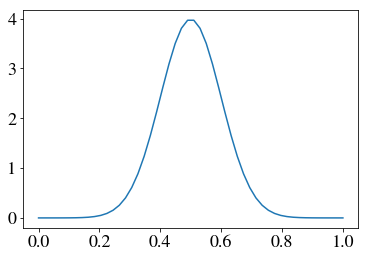

In [89]:
xvals = np.linspace(0, 1)
yvals = gaussian(xvals, 0.5, 0.1)

print(np.trapz(yvals, xvals))

plt.plot(xvals, yvals)

In [5]:
def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

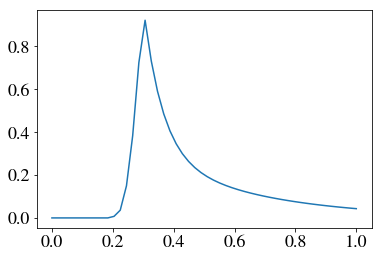

In [102]:
yvals = aflare1(xvals, 0.3, 0.1, 1)

plt.plot(xvals, yvals)

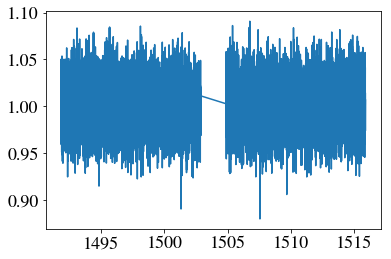

In [29]:
median, s_window = np.loadtxt(path + 'tess2019006130736-s0007-0000000000687046-0131-s_lc.fits.param')
time, flux, error = np.loadtxt(path + 'tess2019006130736-s0007-0000000000687046-0131-s_lc.fits.clean')

plt.plot(time, flux)

In [35]:
# 1 is a flare, 16 is a spurious detection
df = pd.read_csv('7.gauss_flare_out.csv')
print(len(df))

25


tess2019006130736-s0007-0000000014612845-0131-s_lc.fits


(-0.1, 0.6)

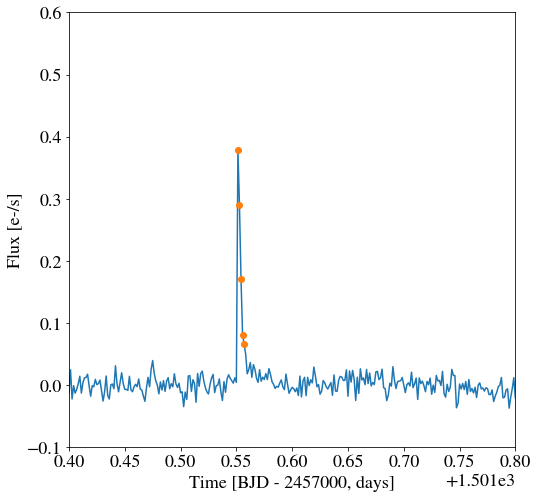

In [203]:
flare_idx = 1
TIC = df.iloc[flare_idx]['TIC']
TIC_str = str(int(TIC)).zfill(16)
file = 'tess2019006130736-s0007-'+TIC_str+'-0131-s_lc.fits'
print(file)

gp_data_file = file + '.gp'
clean_file = file + '.clean'
param_file = file + '.param'
smo, var = np.loadtxt(path + gp_data_file)
time, flux, flux_error = np.loadtxt(path + clean_file)
median, s_window, acf_1dt = np.loadtxt(path + param_file)

tstart = df.iloc[flare_idx]['t0']
tstop = df.iloc[flare_idx]['t1']

x = time
y = flux/median - smo
yerr = np.sqrt((flux_error/median)**2 + var)

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)

indices = np.where((time >= tstart) & (time <= tstop))[0]
axes.plot(x[indices], y[indices], 'o')

axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')
axes.set_xlim(1501.4, 1501.8)
axes.set_ylim(-0.1, 0.6)

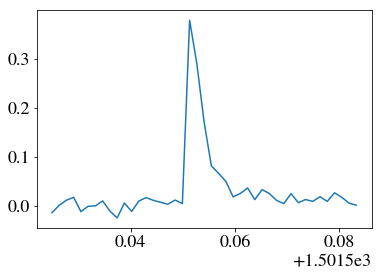

In [204]:
dx_fac = 5
dx = tstop - tstart
x1 = tstart - dx*dx_fac
x2 = tstop + dx*dx_fac
mask = (x > x1) & (x < x2)

plt.plot(x[mask], y[mask])

In [205]:
import scipy.stats as stats

def likelihood(y_model, ydata, yerr, dof):
    chi2 = np.sum((ydata - y_model)**2/yerr**2)/dof
    return stats.chi2(dof).pdf(chi2)

1501.5540682578403 0.002777737504743527
[1.50155248e+03 2.09978153e-03]
1.006104797782686e-21


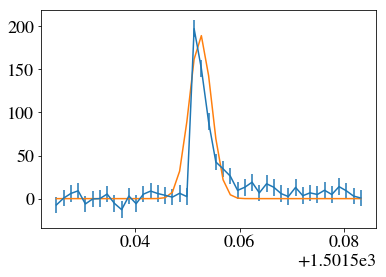

In [206]:
from scipy.optimize import curve_fit

A = np.trapz(y[mask], x[mask])

mu0 = (tstart + tstop)/2
sig0 = (tstop - tstart)/2
print(mu0, sig0)

popt, pcov = curve_fit(gaussian, x[mask], y[mask]/A, p0=(mu0, sig0), sigma=yerr[mask]/A)
print(popt)
y_model = gaussian(x[mask], popt[0], popt[1])

l1 = likelihood(y_model, y[mask]/A, yerr[mask]/A, 2)
print(l1)

plt.errorbar(x[mask], y[mask]/A, yerr=yerr[mask]/A)
plt.plot(x[mask], y_model)

[1.50155160e+03 1.62475883e-03 5.87914075e-01]
0.042703105311438


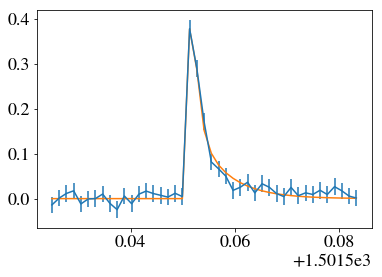

In [207]:
popt, pcov = curve_fit(aflare1, x[mask], y[mask], p0=(mu0, sig0, 1), sigma=yerr[mask])
print(popt)
y_model = aflare1(x[mask], popt[0], popt[1], popt[2])

l2 = likelihood(y_model, y[mask], yerr[mask], 3)
print(l2)

plt.errorbar(x[mask], y[mask], yerr[mask])
plt.plot(x[mask], y_model)

(1502.6, 1502.9)

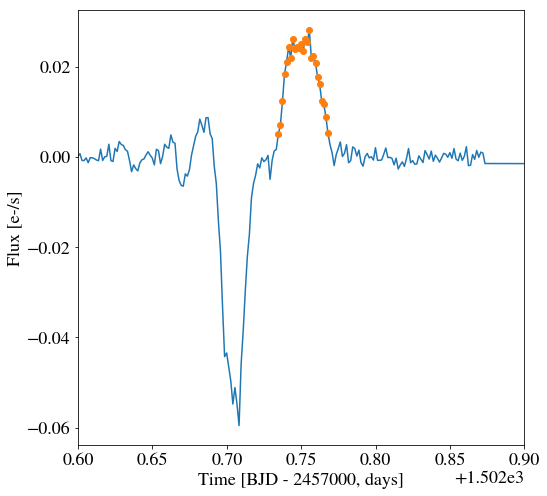

In [208]:
flare_idx = 16
TIC = df.iloc[flare_idx]['TIC']
TIC_str = str(int(TIC)).zfill(16)
file = 'tess2019006130736-s0007-'+TIC_str+'-0131-s_lc.fits'

gp_data_file = file + '.gp'
clean_file = file + '.clean'
param_file = file + '.param'
smo, var = np.loadtxt(path + gp_data_file)
time, flux, flux_error = np.loadtxt(path + clean_file)
median, s_window, acf_1dt = np.loadtxt(path + param_file)

tstart = df.iloc[flare_idx]['t0']
tstop = df.iloc[flare_idx]['t1']

x = time
y = flux/median - smo
yerr = np.sqrt((flux_error/median)**2 + var)

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)

indices = np.where((time >= tstart) & (time <= tstop))[0]
axes.plot(x[indices], y[indices], 'o')

axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')
axes.set_xlim(1502.6, 1502.9)
#axes.set_ylim(-0.1, 0.6)

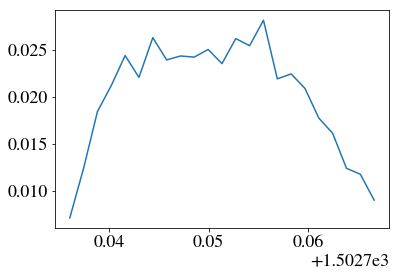

In [217]:
dx = tstop - tstart
x1 = tstart #- dx*dx_fac
x2 = tstop #+ dx*dx_fac
mask = (x > x1) & (x < x2)

plt.plot(x[mask], y[mask])

1502.7513315102801 0.01666642176883215
[1.50275051e+03 9.71376170e-03]
5.108509292662132e-12


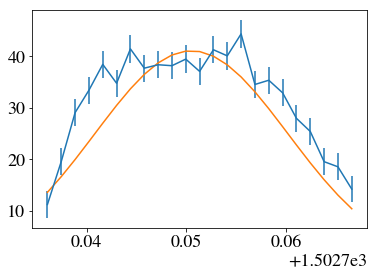

In [224]:
A = np.trapz(y[mask], x[mask])

mu0 = (tstart + tstop)/2
sig0 = (tstop - tstart)/2
print(mu0, sig0)

popt, pcov = curve_fit(gaussian, x[mask], y[mask]/A, p0=(mu0, sig0), sigma=yerr[mask]/A)
print(popt)
y_model = gaussian(x[mask], popt[0], popt[1])

l1 = likelihood(y_model, y[mask]/A, yerr[mask]/A, 2)
print(l1)

plt.errorbar(x[mask], y[mask]/A, yerr=yerr[mask]/A)
plt.plot(x[mask], y_model)

[1.50274658e+03 3.19284039e-02 2.92194056e-02]
7.552418935399471e-07


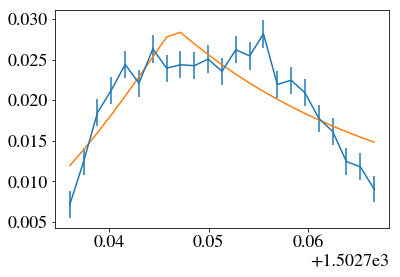

In [219]:
popt, pcov = curve_fit(aflare1, x[mask], y[mask], p0=(mu0, sig0, 1), sigma=yerr[mask])
print(popt)
y_model = aflare1(x[mask], popt[0], popt[1], popt[2])

l2 = likelihood(y_model, y[mask], yerr[mask], 3)
print(l2)

plt.errorbar(x[mask], y[mask], yerr=yerr[mask])
plt.plot(x[mask], y_model)